
================ WALK-FORWARD DIAGNOSTICS ================

 fold  n_train  n_test  baseline_acc  train_acc  test_acc  sharpe  max_dd  avg_prob_up  avg_exposure  pct_leveraged_days
    1      337     335        0.5493     0.6231    0.5104  0.4514 -0.2325       0.5249        1.0463              0.0925
    2      672     335        0.5851     0.6384    0.5522  0.5374 -0.4640       0.5376        1.1522              0.2478
    3     1007     335        0.5463     0.5998    0.5522  0.4495 -0.1342       0.5408        1.0507              0.1015
    4     1342     335        0.4866     0.6080    0.4806  0.1952 -0.2717       0.5947        1.4104              0.7045
    5     1677     335        0.5851     0.5969    0.5731  1.6019 -0.0942       0.5620        1.0075              0.0149

Column meanings:

fold                (walk-forward split index)
n_train             (training samples)
n_test              (out-of-sample test samples)
baseline_acc        (accuracy of always-UP benchmark)
train

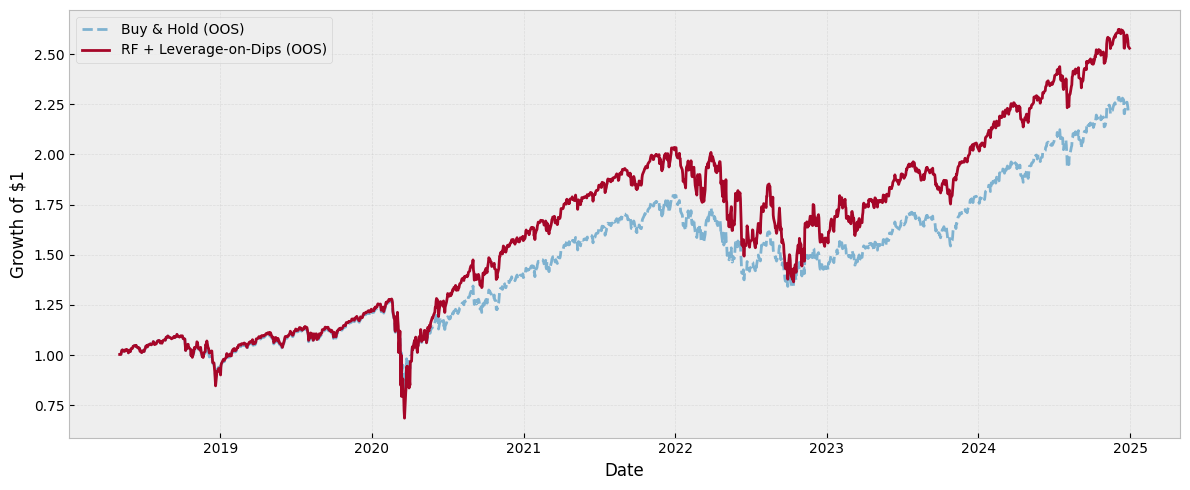

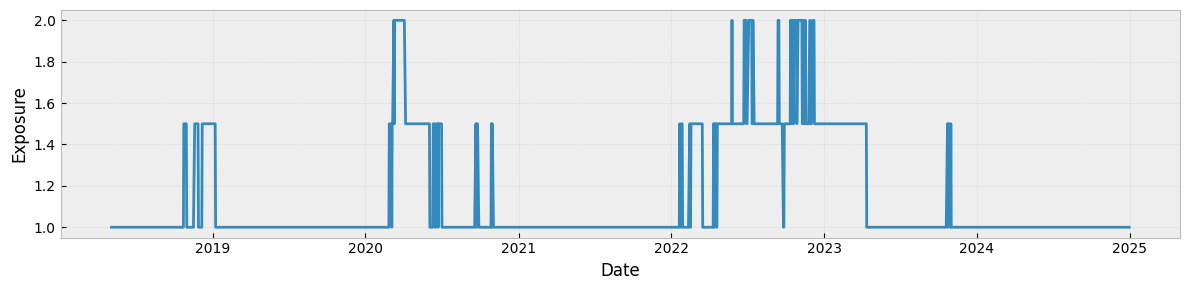

In [1]:
# pip install yfinance scikit-learn pandas numpy matplotlib --quiet
# Quick one-liner installs — makes the notebook/script reproducible on a new machine.

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
# Core stack: numpy for fast math, pandas for time-series tables, yfinance for market data, matplotlib for plots.

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
# ML bits: RF for non-linear classification, PCA to compress momentum signals,
# scaler because PCA cares about scale, TimeSeriesSplit to avoid look-ahead bias, accuracy for a simple sanity check.

plt.style.use("bmh")
# Just nicer plotting style (doesn't change results).

# -----------------------------
# config
# -----------------------------
TICKER = "SPY"
START_DATE = "2016-01-01"
END_DATE = "2025-01-01"
# Trade a liquid proxy (SPY) and fix a date range so the backtest is reproducible.

N_SPLITS = 5
COST_PER_TRADE = 0.0002
# Walk-forward folds for time-series validation.
# Simple transaction cost model (approx slippage/fees) applied when exposure changes.

BASE_EXPOSURE = 1.0
MAX_LEVERAGE_ADD = 1.0
# Default is 1x invested. We allow up to +1x extra (so max 2x total exposure).

DD_MED = -0.08
DD_STRONG = -0.15
# “Dip” definitions: -8% and -15% drawdown from the 1-year peak.

PROB_MED = 0.55
PROB_STRONG = 0.62
# Only add leverage if the model is confident enough.

LEV_ADD_WEAK = 0.0
LEV_ADD_MED = 0.5
LEV_ADD_STRONG = 1.0
# Position sizing: 1x normally, 1.5x on medium dip + confidence, 2x on strong dip + higher confidence.

RF_PARAMS = dict(
    n_estimators=500,
    max_depth=5,
    min_samples_leaf=50,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
# RF is regularized on purpose (shallow trees, big leaf size) to reduce overfitting on noisy daily data.
# Many trees for stability, random_state for reproducibility, n_jobs=-1 for speed.

# -----------------------------
# data
# -----------------------------
print(f"Downloading {TICKER} data...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)
# Pull OHLCV from Yahoo Finance. Note: auto_adjust=False means returns are based on raw Close (not dividend-adjusted).

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
# yfinance sometimes returns multi-level columns; flatten so downstream code is consistent.

df = df[["Open", "High", "Low", "Close", "Volume"]].copy()
# Keep only what we need and copy to avoid pandas chained-assignment issues later.

# -----------------------------
# features
# -----------------------------
df["fwd_ret_1"] = np.log(df["Close"].shift(-1) / df["Close"])
# Next-day log return (tomorrow vs today). This is what the strategy earns if we hold overnight.

df["log_ret_1"] = np.log(df["Close"] / df["Close"].shift(1))
# Daily log return for volatility estimation.

df["vol_20"] = df["log_ret_1"].rolling(20).std()
# 20-day realized volatility — helps the model understand risk regime (calm vs choppy markets).

df["dist_sma50"] = (df["Close"] / df["Close"].rolling(50).mean()) - 1
# Distance from 50-day moving average — captures trend / mean-reversion context.

delta = df["Close"].diff()
# Price changes needed for RSI calculation.

gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["rsi_14"] = 100 - (100 / (1 + rs))
# RSI(14): a standard momentum oscillator — summarises recent up vs down pressure.

df["roc_10"] = df["Close"].pct_change(10)
df["roc_30"] = df["Close"].pct_change(30)
# 10-day and 30-day momentum — two horizons so we’re not betting on a single timescale.

df["roll_peak_252"] = df["Close"].rolling(252).max()
df["dd_252"] = df["Close"] / df["roll_peak_252"] - 1
# 1-year rolling peak and drawdown from that peak — this is the “dip detector”.

df["target"] = (df["fwd_ret_1"] > 0).astype(int)
# Classification label: 1 if next day is up, else 0.

df.dropna(inplace=True)
# Rolling windows create NaNs at the start — drop to get a clean dataset.

momentum_cols = ["rsi_14", "roc_10", "roc_30"]
# The momentum features we’ll compress into a single factor using PCA.

# -----------------------------
# walk-forward
# -----------------------------
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
# Time-series CV so we never train on the future (no leakage).

fold_rows = []
oos_frames = []
fold_imps = []
# Store fold-level metrics, out-of-sample return series, and feature importances.

def zscore_by_train(train_s, test_s):
    mu = train_s.mean()
    sd = train_s.std(ddof=0)
    if not np.isfinite(sd) or sd == 0:
        sd = 1.0
    return (train_s - mu) / sd, (test_s - mu) / sd
# Z-score using only training stats (important to avoid look-ahead).
# Guard against sd=0/NaN so the pipeline never breaks on edge cases.

for fold, (train_idx, test_idx) in enumerate(tscv.split(df), start=1):
    train = df.iloc[train_idx].copy()
    test = df.iloc[test_idx].copy()
    # Walk-forward split: train on the past, test on the next chunk.

    scaler = StandardScaler()
    mom_train = scaler.fit_transform(train[momentum_cols])
    mom_test = scaler.transform(test[momentum_cols])
    # Scale momentum features because PCA is scale-sensitive (RSI vs ROC are on different ranges).
    # Fit on train only, apply to test to avoid leakage.

    pca = PCA(n_components=1, random_state=42)
    train["alpha_factor"] = pca.fit_transform(mom_train).ravel()
    test["alpha_factor"] = pca.transform(mom_test).ravel()
    # Turn multiple momentum signals into one “momentum factor” to reduce noise/collinearity.
    # ravel() just flattens shape (n,1) into (n,) for a clean dataframe column.

    train["vol_z"], test["vol_z"] = zscore_by_train(train["vol_20"], test["vol_20"])
    train["dist_z"], test["dist_z"] = zscore_by_train(train["dist_sma50"], test["dist_sma50"])
    # Standardize these regime features so their scale is stable over time (even though RF doesn’t strictly need it).

    features = ["alpha_factor", "vol_z", "dist_z", "dd_252"]
    # Final feature set: momentum + volatility regime + trend distance + drawdown regime.

    X_train = train[features]
    y_train = train["target"].astype(int)
    X_test = test[features]
    y_test = test["target"].astype(int)
    # Build train/test matrices. Target cast to int to be explicit.

    rf = RandomForestClassifier(**RF_PARAMS)
    rf.fit(X_train, y_train)
    # Fit the classifier on the training window only.

    proba_up = rf.predict_proba(X_test)[:, 1]
    pred = (proba_up >= 0.5).astype(int)
    # Use probabilities (not just class labels) because we convert confidence into position sizing.

    dd = test["dd_252"].values
    lev_add = np.zeros_like(proba_up)
    # Start with no extra leverage; we’ll add only when conditions are met.

    lev_add[(dd <= DD_MED) & (proba_up >= PROB_MED)] = LEV_ADD_MED
    lev_add[(dd <= DD_STRONG) & (proba_up >= PROB_STRONG)] = LEV_ADD_STRONG
    # Strategy rule in plain words:
    # “If SPY is already down from the 1Y high AND the model thinks tomorrow is likely up, scale in harder.”

    exposure = np.clip(BASE_EXPOSURE + lev_add, 0.0, BASE_EXPOSURE + MAX_LEVERAGE_ADD)
    # Final exposure capped to avoid crazy sizing (risk control).

    exposure_change = np.abs(np.diff(np.r_[exposure[0], exposure]))
    strat_ret = exposure * test["fwd_ret_1"].values - COST_PER_TRADE * exposure_change
    mkt_ret = test["fwd_ret_1"].values
    # Strategy return = exposure * next-day return minus trading costs for changing exposure.
    # Market return is just buy-and-hold (1x) for comparison.

    baseline_acc = y_test.mean()
    train_acc = accuracy_score(y_train, rf.predict(X_train))
    test_acc = accuracy_score(y_test, pred)
    # Baseline accuracy = “always predict UP” (since SPY is up more often than down).
    # Train vs test accuracy is a quick overfitting check.

    mu = strat_ret.mean() * 252
    sd = strat_ret.std() * np.sqrt(252)
    sharpe = mu / sd if sd > 0 else 0.0
    # Annualized Sharpe: average return per unit risk.

    cum = np.exp(np.cumsum(strat_ret))
    peak = np.maximum.accumulate(cum)
    max_dd = ((cum - peak) / peak).min()
    # Build equity curve from log returns and compute max drawdown (worst peak-to-trough drop).

    fold_rows.append({
        "fold": fold,
        "n_train": len(train),
        "n_test": len(test),
        "baseline_acc": baseline_acc,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "sharpe": sharpe,
        "max_dd": max_dd,
        "avg_prob_up": proba_up.mean(),
        "avg_exposure": exposure.mean(),
        "pct_leveraged_days": np.mean(exposure > 1.0)
    })
    # Store fold diagnostics so we can see stability across time, not just one final number.

    fold_imps.append(rf.feature_importances_)
    # Track which features the RF relied on (rough importance signal).

    oos_frames.append(pd.DataFrame({
        "Date": test.index,
        "mkt_ret": mkt_ret,
        "strat_ret": strat_ret,
        "exposure": exposure
    }).set_index("Date"))
    # Save out-of-sample time series so we can stitch all folds into one continuous OOS equity curve.

# -----------------------------
# reporting
# -----------------------------
metrics_df = pd.DataFrame(fold_rows)
# Fold-by-fold metrics in a table for readability.

print("\n================ WALK-FORWARD DIAGNOSTICS ================\n")
print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:0.4f}"))
# Print diagnostics: helps spot overfitting (train vs test) and regime dependence.

print("\nColumn meanings:")
print("""
fold                (walk-forward split index)
n_train             (training samples)
n_test              (out-of-sample test samples)
baseline_acc        (accuracy of always-UP benchmark)
train_acc           (in-sample model accuracy)
test_acc            (out-of-sample model accuracy)
sharpe              (annualized risk-adjusted return)
max_dd              (maximum drawdown)
avg_prob_up         (mean predicted probability of UP move)
avg_exposure        (average portfolio exposure)
pct_leveraged_days  (fraction of days leverage > 1.0x)
""")
# Small “legend” so future-me (or interviewer) can read the table fast.

summary = metrics_df[
    ["baseline_acc","train_acc","test_acc","sharpe","max_dd",
     "avg_prob_up","avg_exposure","pct_leveraged_days"]
].mean()
# Average across folds — reduces the chance we over-interpret one lucky period.

print("\n---------------- Summary (mean across folds) ----------------\n")
print(f"baseline_acc       = {summary['baseline_acc']:.4f}  (naive always-UP accuracy)")
print(f"train_acc          = {summary['train_acc']:.4f}  (in-sample accuracy)")
print(f"test_acc           = {summary['test_acc']:.4f}  (out-of-sample accuracy)")
print(f"sharpe             = {summary['sharpe']:.4f}  (risk-adjusted performance)")
print(f"max_dd             = {summary['max_dd']:.4f}  (worst drawdown)")
print(f"avg_prob_up        = {summary['avg_prob_up']:.4f}  (model confidence bias)")
print(f"avg_exposure       = {summary['avg_exposure']:.4f}  (mean exposure)")
print(f"pct_leveraged_days = {summary['pct_leveraged_days']:.4f}  (leverage usage)")
# Print a compact performance summary: accuracy + actual trading metrics.

avg_imp = np.mean(np.vstack(fold_imps), axis=0)
imp = pd.Series(avg_imp, index=["alpha_factor","vol_z","dist_z","dd_252"]).sort_values(ascending=False)
# Average feature importance across folds to avoid one-fold artifacts.

print("\n=== Feature Importance (avg across folds) ===")
for k, v in imp.items():
    meaning = {
        "vol_z": "volatility regime",
        "dd_252": "drawdown from 1Y peak",
        "alpha_factor": "momentum (PCA factor)",
        "dist_z": "distance from trend"
    }.get(k, "")
    print(f"{k:<15} {v:.6f}  ({meaning})")
# Quick interpretation layer: what each feature “means” financially.

# -----------------------------
# equity curves
# -----------------------------
oos = pd.concat(oos_frames).sort_index()
oos["cum_mkt"] = np.exp(oos["mkt_ret"].cumsum())
oos["cum_strat"] = np.exp(oos["strat_ret"].cumsum())
# Stitch all OOS folds together and build cumulative wealth curves (growth of $1).

plt.figure(figsize=(12,5))
plt.plot(oos.index, oos["cum_mkt"], linestyle="--", alpha=0.6, label="Buy & Hold (OOS)")
plt.plot(oos.index, oos["cum_strat"], label="RF + Leverage-on-Dips (OOS)")
plt.legend()
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# Main plot: strategy vs buy-and-hold, strictly out-of-sample.

plt.figure(figsize=(12,3))
plt.plot(oos.index, oos["exposure"])
plt.ylabel("Exposure")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# Exposure plot: shows when/why we took more risk (should line up with drawdowns + high model confidence).
